# Illumination correction

Due to reduced intensity illumination/collection away from the optical axis of the objective lens, it is typical for many microscopes (particularly camera-based systems) to have an illumination bias near the edges of the field-of-view.

To correct for this, we use typically use the [BaSiC method](https://doi.org/10.1038/ncomms14836) to derive two correction matrices from a reference sample. These can then be applied to the raw data to correct the biases. This is implemented in the ``basicpy`` package [https://github.com/peng-lab/BaSiCPy]. This package also covers correction of time-lapse data. We consider both cases in this example.  

## Uneven illumination across the field-of-view

Note: You must run ``notebooks/0_setup.ipynb`` first to specify the configuration and download the test data.

In [1]:
import napari
import numpy as np
import pandas as pb
import basicpy
from aicsimageio import AICSImage
from matplotlib import pyplot as plt

from blimp.data import load_example_data
from blimp.log import configure_logging
from blimp.constants import blimp_config
from blimp.preprocessing.registration import (
    calculate_shifts,
    apply_shifts,
    register_2D,
    transform_2D,
    TransformationParameters
)
from aicsimageio import AICSImage
from pathlib import Path


configure_logging(verbosity=2)
# ensure that example data is downloaded
load_example_data()
# read correct blimp_config -- created with 0_setup.ipynb
blimp_config.config_fname = "blimp.ini"
print(blimp_config)

Reading config from /Users/scottberry/source/blimp/notebooks/blimp.ini
unpacked_dir = /Users/scottberry/source/blimp/notebooks/_data/raw
archive_path = /Users/scottberry/source/blimp/notebooks/_data/archive/_data.zip
Reading config from blimp.ini
BLIMPConfig (fname: blimp.ini)
EXPERIMENT_DIR: /Users/scottberry/source/blimp/notebooks/_experiments
BASE_DATA_DIR: /Users/scottberry/source/blimp/notebooks/_data/raw
data_config/exampledata: /Users/scottberry/source/blimp/notebooks/ExampleData_constants.py



The following images are dyes in solution (Alexa-488, Alexa-568, Alexa-647) imaged on the Nikon N-storm. We combine two individual images from different YX-positions along the 'T' axis of the ``AICSImage``. 

In [10]:
bf1 = AICSImage(Path(blimp_config.BASE_DATA_DIR) / '_data' / 'nstorm_illumination_bias' /  '221103_brightfield_488_568_647_1.nd2')
bf2 = AICSImage(Path(blimp_config.BASE_DATA_DIR) / '_data' / 'nstorm_illumination_bias' /  '221103_brightfield_488_568_647_2.nd2')

# here we use 'T' as the multi-point axis
bf = AICSImage(
    np.stack(
        [
            bf1.get_image_dask_data('CZYX'),
            bf2.get_image_dask_data('CZYX'),
        ],
        axis=0),
    physical_pixel_sizes = bf1.physical_pixel_sizes,
    channel_names=bf1.channel_names
)

In [11]:
bf.shape

(2, 3, 1, 2048, 2044)

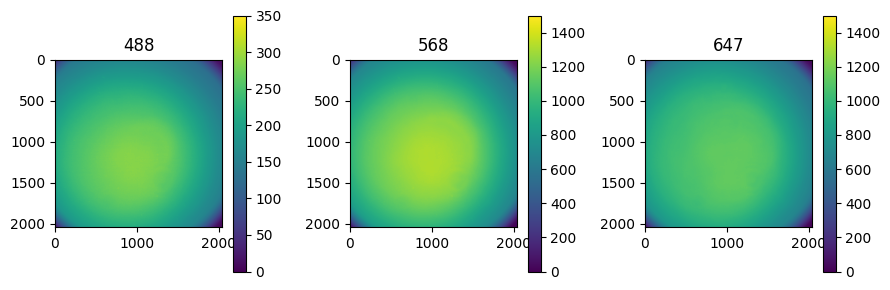

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(bf.get_image_data('YX',C=0,T=0), vmin=0, vmax=350)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("488")
im = axes[1].imshow(bf.get_image_data('YX',C=1,T=0), vmin=0, vmax=1500)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("568")
im = axes[2].imshow(bf.get_image_data('YX',C=2,T=0), vmin=0, vmax=1500)
fig.colorbar(im, ax=axes[2])
axes[2].set_title("647")
fig.tight_layout()

We can use basicpy to correct these artefacts

In [44]:
illum_corr = [basicpy.BaSiC() for _ in range(3)]
[illum_corr[c].fit(bf.get_image_data('TYX',C=c)) for c in range(3)]

[None, None, None]

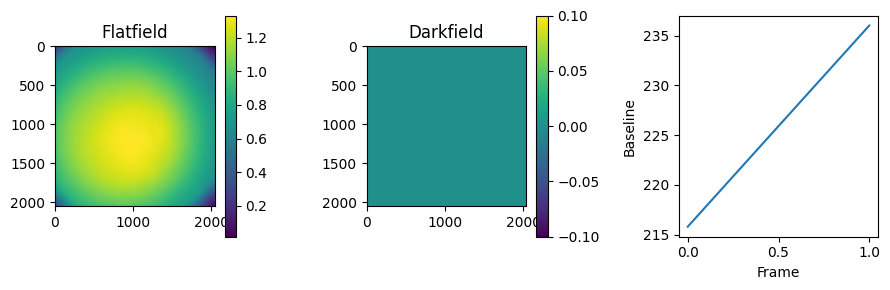

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(illum_corr[0].flatfield)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(illum_corr[0].darkfield)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(illum_corr[0].baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

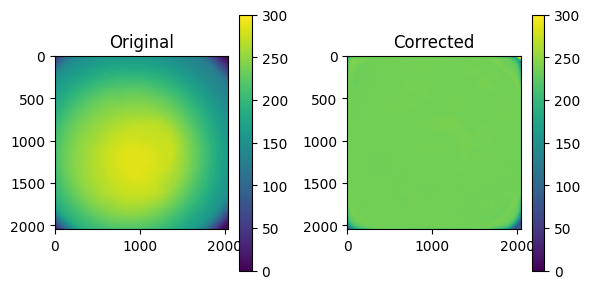

In [46]:
bf_transformed = illum_corr[0].transform(bf.get_image_data('TYX',C=0))
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
im = axes[0].imshow(bf.get_image_data('YX',C=0,T=0), vmin=0, vmax=300)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Original")
im = axes[1].imshow(bf_transformed[1], vmin=0, vmax=300)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Corrected")
fig.tight_layout()

If a brightfield image is not avaliable, this can be generated by averaging or concatenating a set of input images

In [83]:
from basicpy import BaSiC as BasicIlluminationCorrection
from typing import List, Union, overload, Literal
from blimp.utils import check_uniform_dimension_sizes, concatenate_images, average_images
from aicsimageio.transforms import transpose_to_dims

def get_illumination_correction(
    reference_images : List[AICSImage],
    timelapse : bool=False,
    **kwargs
) -> List[BasicIlluminationCorrection]:
    
    try:
        check_uniform_dimension_sizes(reference_images)
    except:
        raise ValueError('Incorrect')

    if not timelapse:
        # use the 'T' axis to concatenate images
        images = concatenate_images(reference_images,axis='T',order='append')
    else:
        # average each timepoint
        images = average_images(reference_images)

    illum_corr = [BasicIlluminationCorrection(**kwargs) for _ in range(images.dims.C)]
    for c in range(images.dims.C):
        illum_corr[c].fit(bf.get_image_data('TYX',C=c))

    return(illum_corr)


def correct_image(
    obj : List[BasicIlluminationCorrection],
    im : AICSImage,
    timelapse : Union[bool, Literal["multiplicative"], Literal["additive"]]=False
):
    if im.dims.C != len(obj):
        raise ValueError(f"Incorrect number of correction objects, expected {im.dims.C}.")
    else:
        if timelapse == False:
            corr = np.stack(
                [np.stack(
                    [np.stack(
                        [obj[c].transform(
                            im.get_image_data('YX',C=c,Z=z,T=t),
                            timelapse=timelapse,
                        )[0] for z in range(im.dims.Z)],
                        axis=0)
                    for c in range(im.dims.C)],
                    axis=0)
                for t in range(im.dims.T)],
                axis=0
            )
        else:
            # correct timelapse data in inner loop and reorder 
            # dimensions afterwards
            corr_CZTYX = np.stack(
                [np.stack(
                    [obj[c].transform(
                        im.get_image_data('TYX',C=c,Z=z),
                        timelapse=timelapse,
                    )[0] for z in range(im.dims.Z)],
                    axis=0)
                for c in range(im.dims.C)],
                axis=0
            )
            corr = transpose_to_dims(corr_CZTYX, given_dims='CZTYX', return_dims='TCZYX')
    return(AICSImage(corr, physical_pixel_sizes=im.physical_pixel_sizes, channel_names=im.channel_names))


@overload
def apply_illumination_correction(
    correction_object : BasicIlluminationCorrection,
    images : AICSImage,
    timelapse : bool=False
) -> AICSImage: ...


@overload
def apply_illumination_correction(
    correction_object : BasicIlluminationCorrection,
    images : List[AICSImage],
    timelapse : bool=False
) -> List[AICSImage]: ...


def apply_illumination_correction(
    correction_objects : BasicIlluminationCorrection,
    images : Union[AICSImage, List[AICSImage]],
    timelapse : Union[bool, Literal["multiplicative"], Literal["additive"]]=False
) -> Union[AICSImage,List[AICSImage]]:

    if not timelapse:
        if isinstance(images,AICSImage):
            return correct_image(correction_objects,images)
        elif isinstance(images,list):
            corrected = [illum_corr[0].transform(images.get_image_data('TYX',C=0))]


In [53]:
correction_objects = get_illumination_correction([bf1,bf2])

In [84]:
a = correct_image(bf1,correction_objects)
a.dims

<Dimensions [T: 1, C: 3, Z: 1, Y: 2048, X: 2044]>

In [77]:
correction_objects[0].transform(bf1.get_image_data('YX',C=0,Z=0,T=0))[0].shape

(2048, 2044)

In [76]:
bf1.get_image_data('YX',C=0,Z=0,T=0).shape

(2048, 2044)

In [ ]:
images = unbleached_images[0:2]
av = average_images(images)
concat = concatenate_images(images)

In [ ]:
av.shape

In [ ]:
concat.shape

In [ ]:
unbleached_images = [AICSImage("/srv/scratch/berrylab/z3532965/Nikon_AX_QPI/20221010_BleachChase_POLR2A/20221010_160654_024/OME-TIFF-MIP/WellE06_ChannelGFP,AF647_Seq0004_00"+ str(i).zfill(2) +".ome.tiff") for i in range(1,17)]

In [ ]:
# generate an average over all sites for each time point

In [ ]:
unbleached_images[0].dims.shape

In [ ]:
average_image_c0 = np.mean([image.get_image_dask_data("TYX", C=0) for image in unbleached_images],axis=0)

In [ ]:
average_image_c1 = np.mean([unbleached_images[i].get_image_data("TYX", C=1) for i in range(0,16)],axis=0)

In [ ]:
viewer = napari.view_image(average_image_c0)

In [ ]:
illum_corr = basicpy.BaSiC(get_darkfield=True, smoothness_flatfield=5,smoothness_darkfield=5)
illum_corr.fit(average_image_c0)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
im = axes[0].imshow(illum_corr.flatfield)
fig.colorbar(im, ax=axes[0])
axes[0].set_title("Flatfield")
im = axes[1].imshow(illum_corr.darkfield)
fig.colorbar(im, ax=axes[1])
axes[1].set_title("Darkfield")
axes[2].plot(illum_corr.baseline)
axes[2].set_xlabel("Frame")
axes[2].set_ylabel("Baseline")
fig.tight_layout()

In [ ]:
corrected = illum_corr.transform(unbleached_images[0].get_image_data("TYX", C=0), timelapse=True) 

In [ ]:
corrected.shape

In [ ]:
for i in range(0, 86, 10):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    im = axes[0].imshow(unbleached_images[0].get_image_data("TYX", C=0)[i])
    fig.colorbar(im, ax=axes[0])
    axes[0].set_title("Original")
    im = axes[1].imshow(corrected[i])
    fig.colorbar(im, ax=axes[1])
    axes[1].set_title("Corrected")
    fig.suptitle(f"frame {i}")
    fig.tight_layout()